The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3


# Multi-Head Attention
:label:`sec_multihead-attention`


In practice, given the same set of queries, keys, and values we may want our model to combine knowledge from
different behaviors of the same attention mechanism,
such as capturing dependencies of various ranges
(e.g., shorter-range vs. longer-range) within a sequence.
Thus, it may be beneficial to allow our attention mechanism to jointly use different representation subspaces of queries, keys, and values.


To this end, instead of performing
a single attention pooling,
queries, keys, and values
can be transformed
with $h$ independently learned linear projections.
Then these $h$ projected queries, keys, and values
are fed into attention pooling in parallel.
In the end,
$h$ attention-pooling outputs
are concatenated and
transformed with another learned linear projection
to produce the final output.
This design
is called *multi-head attention*,
where each of the $h$ attention pooling outputs
is a *head* :cite:`Vaswani.Shazeer.Parmar.ea.2017`.
Using fully connected layers
to perform learnable linear transformations,
:numref:`fig_multi-head-attention`
describes multi-head attention.

![Multi-head attention, where multiple heads are concatenated then linearly transformed.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/multi-head-attention.svg?raw=1)
:label:`fig_multi-head-attention`


In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## Model

Before providing the implementation of multi-head attention,
let's formalize this model mathematically.
Given a query $\mathbf{q} \in \mathbb{R}^{d_q}$,
a key $\mathbf{k} \in \mathbb{R}^{d_k}$,
and a value $\mathbf{v} \in \mathbb{R}^{d_v}$,
each attention head $\mathbf{h}_i$  ($i = 1, \ldots, h$)
is computed as

$$\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v},$$

where
$\mathbf W_i^{(q)}\in\mathbb R^{p_q\times d_q}$,
$\mathbf W_i^{(k)}\in\mathbb R^{p_k\times d_k}$,
and $\mathbf W_i^{(v)}\in\mathbb R^{p_v\times d_v}$
are learnable parameters and
$f$ is attention pooling,
such as
additive attention and scaled dot product attention
in :numref:`sec_attention-scoring-functions`.
The multi-head attention output
is another linear transformation via
learnable parameters
$\mathbf W_o\in\mathbb R^{p_o\times h p_v}$
of the concatenation of $h$ heads:

$$\mathbf W_o \begin{bmatrix}\mathbf h_1\\\vdots\\\mathbf h_h\end{bmatrix} \in \mathbb{R}^{p_o}.$$

Based on this design, each head may attend
to different parts of the input.
More sophisticated functions
than the simple weighted average can be expressed.

## Implementation

In our implementation,
we [**choose the scaled dot product attention
for each head**] of the multi-head attention.
To avoid significant growth of computational cost and parametrization cost,
we set $p_q = p_k = p_v = p_o / h$.
Note that $h$ heads can be computed in parallel
if we set the number of outputs
of linear transformations
for the query, key, and value
to $p_q h = p_k h = p_v h = p_o$.
In the following implementation,
$p_o$ is specified via the argument `num_hiddens`.


In [3]:
class MultiHeadAttention(d2l.Module):  #@save
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

To allow for [**parallel computation of multiple heads**],
the above `MultiHeadAttention` class uses two transposition methods as defined below.
Specifically,
the `transpose_output` method reverses the operation
of the `transpose_qkv` method.


In [4]:
@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

Let's [**test our implemented**] `MultiHeadAttention` class
using a toy example where keys and values are the same.
As a result,
the shape of the multi-head attention output
is (`batch_size`, `num_queries`, `num_hiddens`).


In [5]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
d2l.check_shape(attention(X, Y, Y, valid_lens),
                (batch_size, num_queries, num_hiddens))

## Summary

Multi-head attention combines knowledge of the same attention pooling
via different representation subspaces of queries, keys, and values.
To compute multiple heads of multi-head attention in parallel,
proper tensor manipulation is needed.


## Exercises

1. Visualize attention weights of multiple heads in this experiment.
1. Suppose that we have a trained model based on multi-head attention and we want to prune less important attention heads to increase the prediction speed. How can we design experiments to measure the importance of an attention head?


# EX 1: Visualise Heads

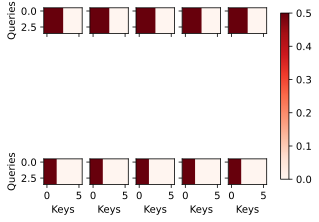

In [19]:
d2l.show_heatmaps(attention.attention.attention_weights.reshape((batch_size, num_heads, num_queries, num_kvpairs)), xlabel='Keys', ylabel='Queries',figsize=(5, 5))

In [6]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))


In [8]:
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def visualize_attention_weights(attention_weights, num_heads, title="Attention Weights"):
    """
    Visualize attention weights for all heads.

    attention_weights: Tensor of shape (batch_size, num_queries, num_hiddens)
    num_heads: Number of attention heads
    """
    # Extract dimensions
    batch_size, num_queries, num_hiddens = attention_weights.shape
    head_dim = num_hiddens // num_heads

    # Reshape to separate heads: (batch_size, num_queries, num_heads, head_dim)
    attention_weights = attention_weights.reshape(batch_size, num_queries, num_heads, head_dim)

    for batch_idx in range(batch_size):  # Loop over batches
        for head in range(num_heads):  # Loop over heads
            plt.figure(figsize=(8, 6))
            # Select attention weights for this head
            head_weights = attention_weights[batch_idx, :, head, :].detach().cpu().numpy()
            sns.heatmap(head_weights, cmap='viridis')
            plt.title(f"{title} - Batch {batch_idx + 1}, Head {head + 1}")
            plt.xlabel("Head Dim")
            plt.ylabel("Queries")
            plt.show()


Shape of attention_weights: torch.Size([2, 4, 100])


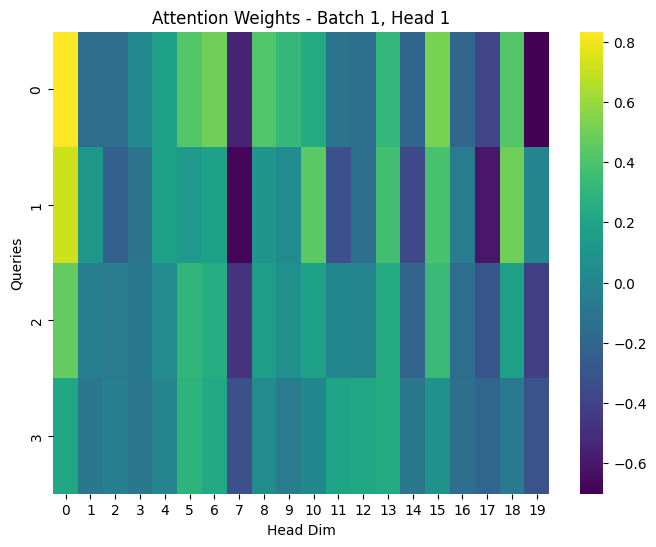

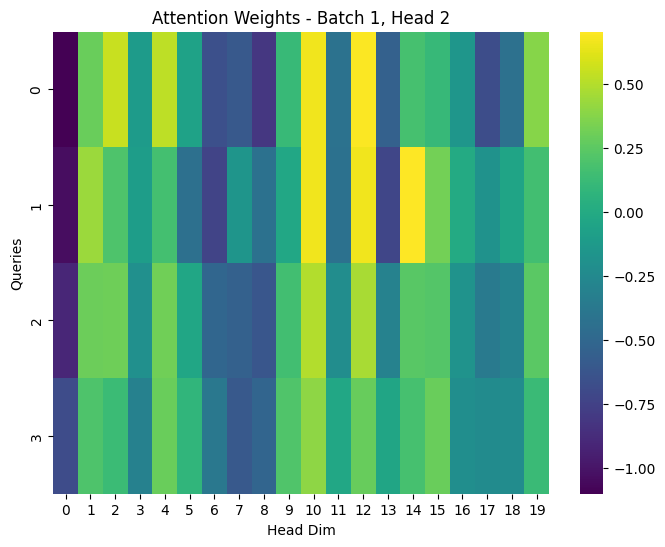

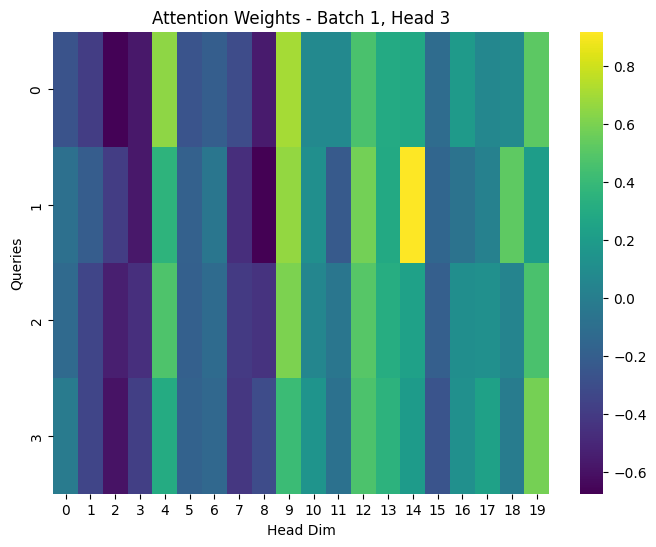

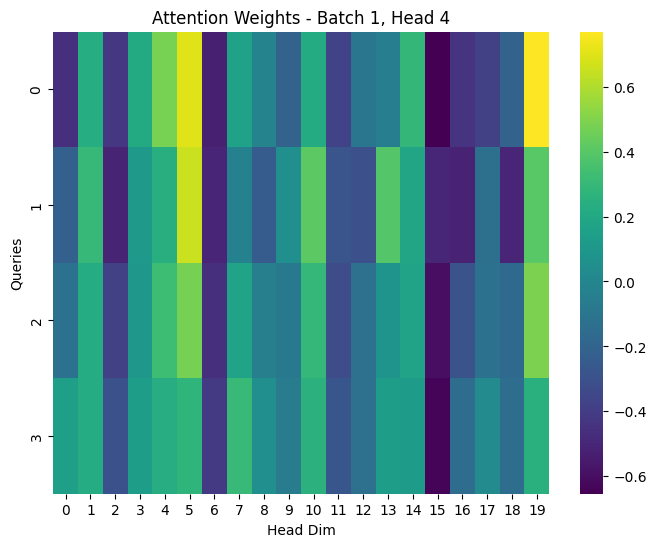

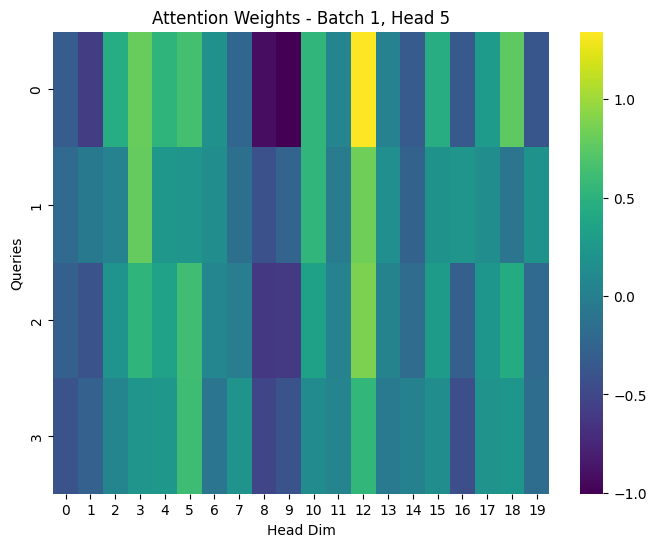

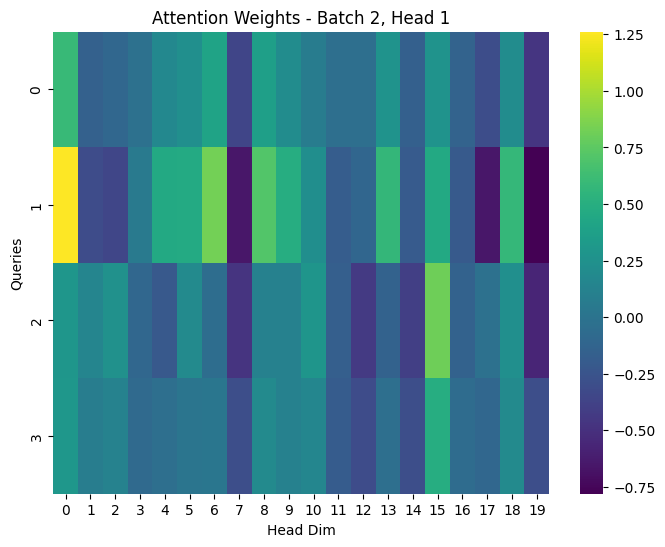

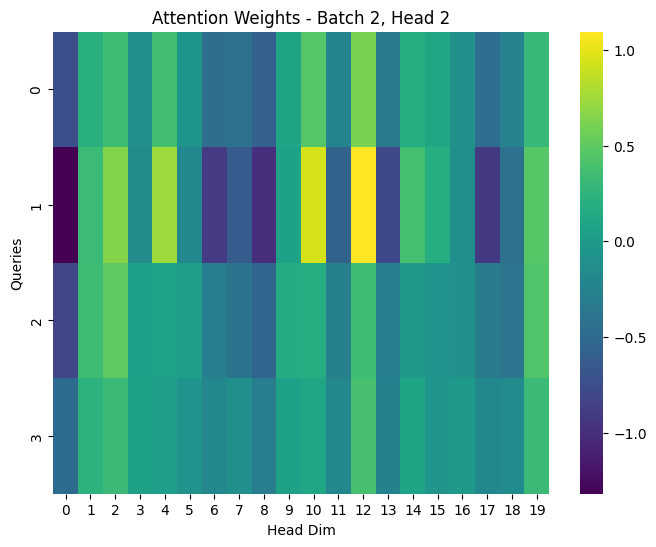

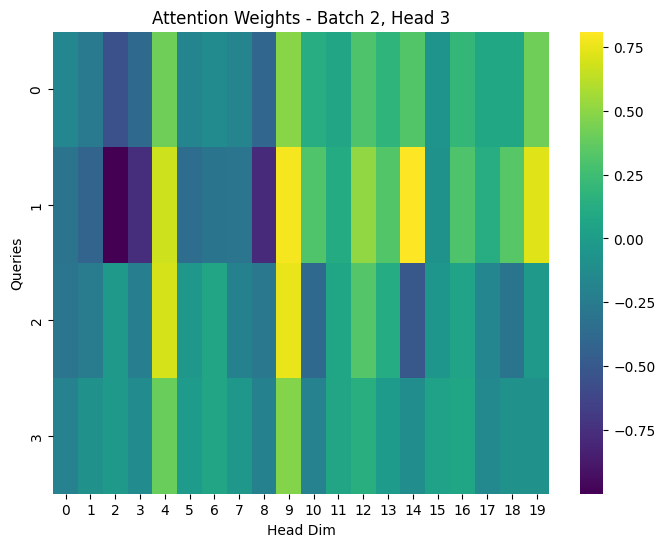

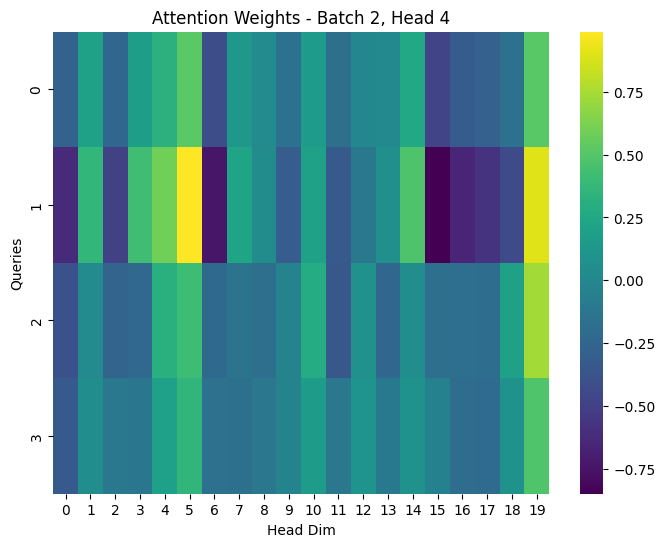

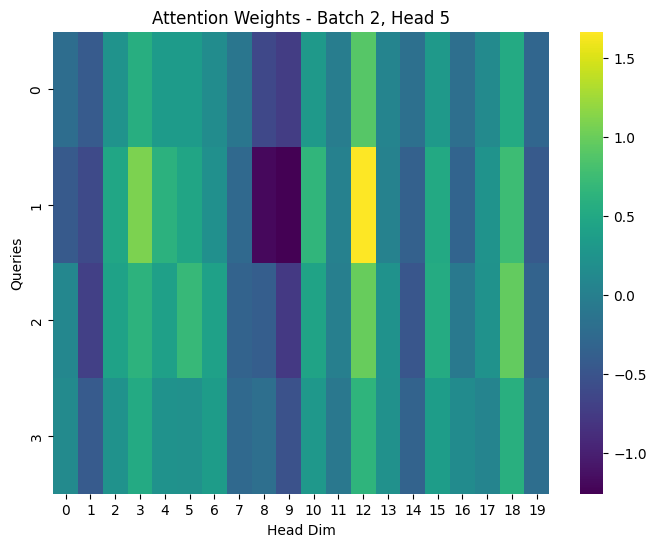

In [17]:
output = attention(X, Y, Y, valid_lens)
print("Shape of attention_weights:", output.shape)

visualize_attention_weights(output, num_heads)

# EX2: Head Pruning

In [23]:
# Compute entropy for each head
def compute_head_entropy(attention_weights, num_heads):
    """
    Compute entropy for attention weights of each head.

    attention_weights: Tensor of shape (batch_size, num_queries, num_hiddens)
    num_heads: Number of attention heads
    """
    batch_size, num_queries, num_hiddens = attention_weights.shape
    head_dim = num_hiddens // num_heads
    # Reshape to (batch_size, num_queries, num_heads, head_dim)
    reshaped_weights = attention_weights.reshape(batch_size, num_queries, num_heads, head_dim)

    # Normalize across head_dim (last axis)
    normalized_weights = reshaped_weights / reshaped_weights.sum(dim=-1, keepdim=True)

    # Compute entropy: -sum(p * log(p))
    entropy = -torch.sum(
        normalized_weights * torch.log(normalized_weights + 1e-9), dim=-1
    )  # Shape: (batch_size, num_queries, num_heads)

    # Average entropy over batch and queries
    avg_entropy = entropy.mean(dim=(0, 1))  # Shape: (num_heads,)
    return avg_entropy


In [24]:
def prune_attention_head(attention_weights, num_heads, least_important_head):
    """
    Mask the least important attention head.

    attention_weights: Tensor of shape (batch_size, num_queries, num_hiddens)
    num_heads: Number of attention heads
    least_important_head: Index of the least important head
    """
    batch_size, num_queries, num_hiddens = attention_weights.shape
    head_dim = num_hiddens // num_heads

    # Reshape to (batch_size, num_queries, num_heads, head_dim)
    reshaped_weights = attention_weights.reshape(batch_size, num_queries, num_heads, head_dim)

    # Mask the least important head
    reshaped_weights[:, :, least_important_head, :] = 0

    # Reshape back to original shape
    pruned_weights = reshaped_weights.reshape(batch_size, num_queries, num_hiddens)
    return pruned_weights


In [25]:
# Simulate attention weights
batch_size, num_queries, num_hiddens, num_heads = 2, 4, 100, 5
attention_weights = torch.rand(batch_size, num_queries, num_hiddens)

# Compute entropy for each head
head_entropy = compute_head_entropy(attention_weights, num_heads)
print("Head Entropy:", head_entropy)

# Identify the least important head
least_important_head = torch.argmin(head_entropy).item()
print("Least Important Head:", least_important_head)

# Prune the least important head
pruned_attention_weights = prune_attention_head(attention_weights, num_heads, least_important_head)
print("Pruned Attention Weights Shape:", pruned_attention_weights.shape)

Head Entropy: tensor([2.7627, 2.7940, 2.8222, 2.8160, 2.8597])
Least Important Head: 0
Pruned Attention Weights Shape: torch.Size([2, 4, 100])


[Discussions](https://discuss.d2l.ai/t/1635)
